In [1]:
import warnings
warnings.filterwarnings("ignore")

HINT: in case of low memory: work with low sample

# Import Libraries & define functions

## Library versions

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
# pip install geopy
from geopy.geocoders import Nominatim
from tqdm import tqdm
from datetime import datetime


In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, accuracy_score, plot_roc_curve, roc_curve, confusion_matrix, recall_score, precision_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split,learning_curve, cross_val_score, KFold
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.decomposition import PCA

# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier
# from lightgbm import plot_importance

## Universal Created Functions

In [4]:
def plot_prec_and_rec(y_pred_proba,
                      y_test,
                      title='Recall and Precision vs. threshold',
                      thres_acc = 0.5):
    """Receives an pandas series or array for predicted results and an array of test values and plots a graph for comparation
    It also shows the accuracy score for threshold 50. It also receives a threshold for acc_score"""
    
    if type(y_pred_proba) != type(pd.Series()):
        y_pred_proba = pd.Series(y_pred_proba)
    
    recall_scores = []
    precision_scores = []

    for treshold in np.arange(0,1.05,0.05):

        thresh_pred = y_pred_proba.apply(lambda x: 1 if x >= treshold -0.01 else 0)

        recall_scores.append(recall_score(y_test,thresh_pred))
        precision_scores.append(precision_score(y_test,thresh_pred))
    
    #accuracy score
    thresh50 = y_pred_proba.apply(lambda x: 1 if x >= thres_acc else 0)
    acc_score = round(accuracy_score(y_test,thresh50),4)
    
    sns.lineplot(x=np.arange(0,1.05,0.05), y=precision_scores, label='precision')
    sns.lineplot(x=np.arange(0,1.05,0.05), y=recall_scores, label='recall')
    plt.title(title + f'\nacc. score (threshold = {thres_acc}) {acc_score}')
    plt.xlabel('Threshold')
    plt.ylabel('Precision / Recall')
    plt.legend()
    plt.show()

**LEARNING CURVE**

In [6]:
def make_my_learn_curve(model, X_train, y_train, cv=KFold(10), scoring='roc_auc'):
    print('start:', datetime.now().strftime('%H:%M:%S'))

    curve = learning_curve(model, X_train, y_train, cv=KFold(10), scoring='roc_auc')
    
    train_sizes = curve[0]
    train_scores = curve[1]
    test_scores = curve[2]

    plt.plot(train_sizes, train_scores.mean(axis=1), '-o', label='Training AUC')
    plt.plot(train_sizes, test_scores.mean(axis=1), '-o', label='Test AUC')
    plt.ylim([0., 1])
    plt.xlabel('Training Sizes')
    plt.ylabel('Scores')
    plt.legend(loc=4)
    plt.grid()
    
    print('end:', datetime.now().strftime('%H:%M:%S'))


# Import Datasets & merge

Problems found:
* Dataset was separated in many files
* Some files had the same columns with slightly different names
* Some dataset parts were clone of others

In [222]:
path = 'processo_cientista-master/data/'

data = pd.read_csv(path+'rain_data_aus.csv')
winds = pd.DataFrame()

for number in [1,2,3,4,5,6,7,8]:
    df = pd.read_csv(path+f'wind_table_0{number}.csv')
    df.columns = ['date', 'location', 'wind_gustdir', 'wind_gustspeed', 'wind_dir9am',
       'wind_dir3pm', 'wind_speed9am', 'wind_speed3pm']
    winds = pd.concat([winds,df])

data = pd.merge(data, winds, on=['date','location'])

data = data.drop_duplicates()

**Quick change in data before baseline**
* Rain data needed also to be standardized to 1s and 0s.
* Date was type strings, so we changed them to datetime

In [223]:
# date string to date datetime:
data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'])

data.loc[:,'raintoday'] = data.loc[:,'raintoday'].apply(lambda x: 0 if x == 'No' else x)
data.loc[:,'raintoday'] = data.loc[:,'raintoday'].apply(lambda x: 1 if x == 'Yes' else x)
data.loc[:,'raintomorrow'] = data.loc[:,'raintomorrow'].apply(lambda x: 0 if x == 'No' else x)
data.loc[:,'raintomorrow'] = data.loc[:,'raintomorrow'].apply(lambda x: 1 if x == 'Yes' else x)

and save a backup!

In [224]:
data.to_csv('raw_data_backup.csv',index=False)

# Creating Baseline

Quick thinking: since we are dealing with a time series, it was decided to use **the last year** for validation of the model (testing), and the rest for training

In [42]:
train = data.loc[data.date <= '2016-06-24'].dropna()
test = data.loc[data.date > '2016-06-24'].dropna()

A quick look at the data showed that **raintomorrow** was probably the **target**. We also dropped the missing values.

In [68]:
X_train = pd.get_dummies(train.drop(['raintomorrow','date'],axis=1))
y_train = train.loc[:,'raintomorrow']

X_test = pd.get_dummies(test.drop(['raintomorrow','date'],axis=1))
y_test = test.loc[:,'raintomorrow']

# set equal number of columns
for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

In [51]:
# Standardize data:
scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)

X_test_std = scaler.transform(X_test)

In [52]:
#instantiate the model and fit
logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train_std, y_train)

# let's evaluate - new data comes in:
predictions = logreg.predict(X_test_std)
pred_proba = logreg.predict_proba(X_test_std)

results = pd.DataFrame({'prob_not_rain': pred_proba[:,0], 
                          'prob_rain': pred_proba[:,1], 
                          'predictions':predictions,
                          'y_test':y_test})

accuracy_score(y_test, predictions)

0.967741935483871

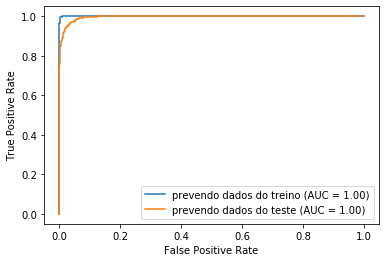

In [55]:
# results
fig, ax = plt.subplots()

plot_roc_curve(logreg, X_train_std, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(logreg, X_test_std, y_test, ax=ax, name = 'prevendo dados do teste')
plt.show();

Now, we might take a look at some columns!

# Exploring Data

**Analysis of *modelo_vigente***

Here we can analyse if the *modelo_vigente* would be the probability of raining in the next day.
In other words, woud be the prediction of the column *raintomorrow*

In [60]:
# verificar futuramente: a distribuição dessas probabilidades.
# isso ajudaria analisar qual seria o "corte" ideal do modelo.
# cuidado com a organização do nome das variáveis.

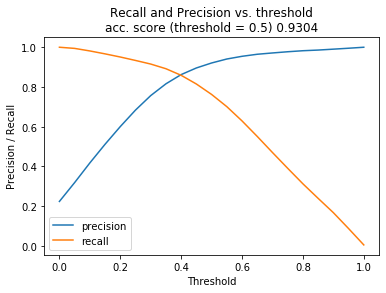

In [211]:
data_mv = data.loc[:,['raintomorrow','modelo_vigente']]

y_pred_proba = data.loc[:,'modelo_vigente']
y_test = data.loc[:,'raintomorrow']

plot_prec_and_rec(y_pred_proba = y_pred_proba, y_test = y_test)

Now we may consider *modelo_vigente* to be some model that we can drop from our data!

## Relationships Analysis

*Summary:*

* raintoday is dependend from rainfall
* raintomorrow is dependend from amountOfRain
* rainfall and amountOfRain are equal, but in different times (respectively, t and t+1)
* temp has high correlation with maxtemp, and can be discarded

**relationship *raintoday* and *rainfall***: *raintoday* seems to be derived from *rainfall*

In [214]:
# code here
xmax = data.loc[data.raintoday == 0].rainfall.max()
xmin = data.loc[data.raintoday == 0].rainfall.min()
yesmin = data.loc[data.raintoday == 1].rainfall.min()
print(f'minimum rainfall for necessary for raintoday = False: {xmin}')
print(f'maximum rainfall for necessary for raintoday = False: {xmax}')
print(f'minimum rainfall for necessary for raintoday = True: {yesmin}')

minimum rainfall for necessary for raintoday = False: 0.0
maximum rainfall for necessary for raintoday = False: 1.0
minimum rainfall for necessary for raintoday = True: 1.1


**relationship *raintomorrow* and *amountOfRain***: *raintomorrow* seems to be derived from *amountOfRain*

In [215]:
# code here
x_true_min = data.loc[(data.raintomorrow == 0)].amountOfRain.min()
x_true_max = data.loc[(data.raintomorrow == 0)].amountOfRain.max()
x_false_min = data.loc[(data.raintomorrow == 1)].amountOfRain.min()
print(f'minimum rainfall for necessary for raintomorrow = False: {x_true_min}')
print(f'maximum rainfall for necessary for raintomorrow = False: {x_true_max}')
print(f'minimum rainfall for necessary for raintomorrow = True: {x_false_min}')

minimum rainfall for necessary for raintomorrow = False: 0.0
maximum rainfall for necessary for raintomorrow = False: 1.0
minimum rainfall for necessary for raintomorrow = True: 1.1


**relationship *rainfall* and *amountOfRain***: However, if we consider rainfall being on time 'T' and amountOfRain bein on time 'T+1', if we bring them to the same time window, we can see a really high High correlation between 

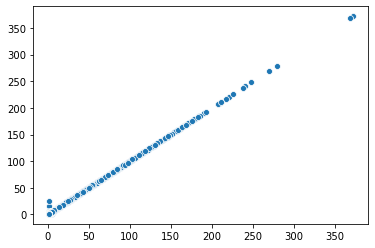

In [216]:
# code here
expectancy = np.array(data.amountOfRain[0:-1]) + 1
reality = np.array(data.rainfall[1:]) + 1

error = (expectancy - reality)/reality *100

sns.scatterplot(x=expectancy, y=reality)

**Discrepancy between rainfall/raintoday and raintomorrow/amountOfRain**

Apart from the 1406 missing values of *rainfall*/*raintoday*, *raintomorrow*/*amountOfRain* should be
similar, since the seconds "would be" the first ones in a time t+1.

However, we have 13 rows with discrepant values between the two pairs!

In [22]:
# code here
pd.concat(  [data.rainfall[1:].reset_index(drop=True), 
             data.raintoday[1:].reset_index(drop=True),
             data.raintomorrow[0:-1].reset_index(drop=True),
             data.amountOfRain[0:-1].reset_index(drop=True)
            ],axis=1).dropna().query('raintoday != raintomorrow')

,rainfall,raintoday,raintomorrow,amountOfRain
2607,0.0,No,Yes,3.8
2609,3.8,Yes,No,0.0
2615,0.0,No,Yes,3.6
2617,3.6,Yes,No,0.0
2631,0.0,No,Yes,8.6
...,...,...,...,...
164114,2.8,Yes,No,0.2
164118,0.4,No,Yes,6.2
164120,6.2,Yes,No,0.2
164248,0.0,No,Yes,6.8


**temperature columns**

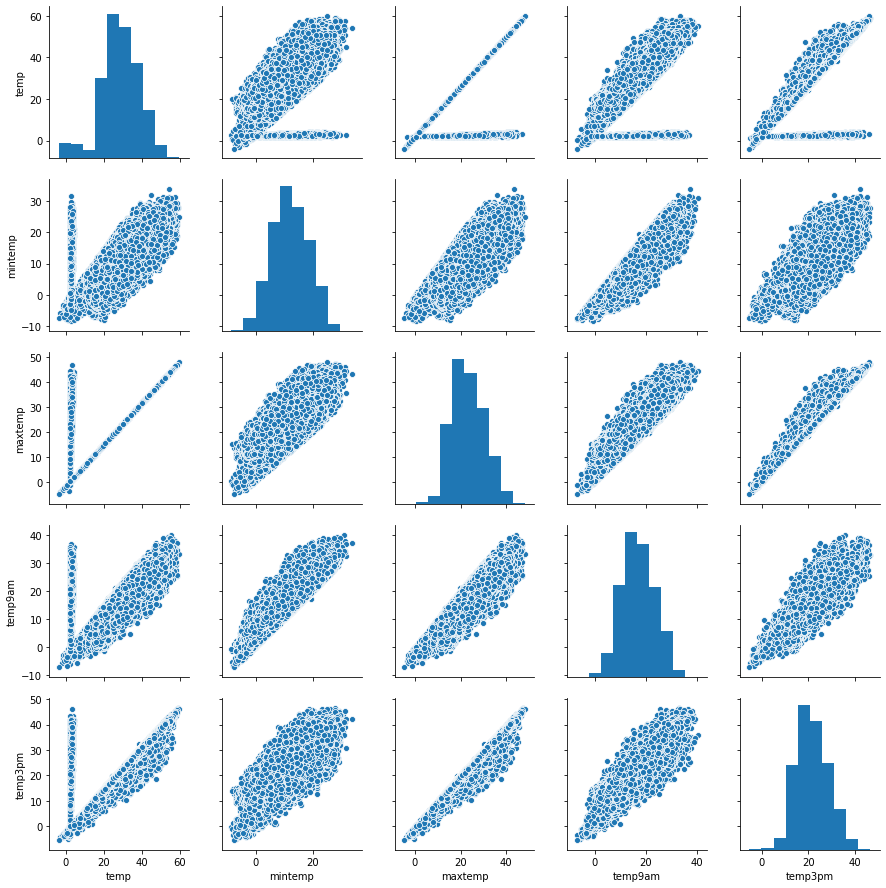

In [218]:
sns.pairplot(data.loc[:,['temp', 'mintemp', 'maxtemp', 'temp9am', 'temp3pm']])

**pressure columns**

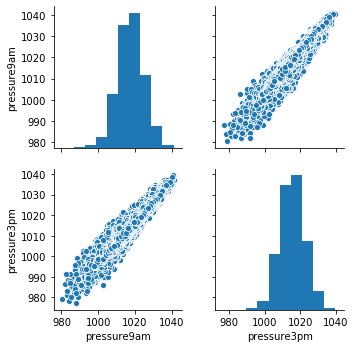

In [219]:
pressure = data.loc[:,['pressure9am', 'pressure3pm']]
sns.pairplot(pressure)

**humidity columns**

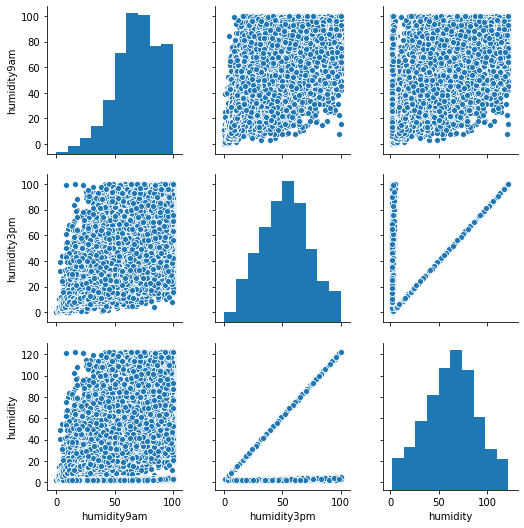

In [220]:
humidity = data.loc[:,['humidity9am', 'humidity3pm', 'humidity']]
sns.pairplot(humidity)

In [26]:
print('porcentagem de dados nulos:\n')
print(round(winds.isna().sum()/data.shape[0]*100))

porcentagem de dados nulos:

date              0.0
location          0.0
wind_gustdir      6.0
wind_gustspeed    6.0
wind_dir9am       7.0
wind_dir3pm       3.0
wind_speed9am     1.0
wind_speed3pm     2.0
dtype: float64


## **Rain data: analysis**

* looking only at rainfall we can see that different years have different amounts of rain, this also varies for each city/location.

In [ ]:
#data for analysis
prec = data.loc[:,['date', 'location', 'rainfall', 'precipitation3pm','precipitation9am']]
prec.loc[:,'date'] =  pd.to_datetime(prec.loc[:,'date'])
prec = prec.loc[prec.date <= '2016-06-24']

In [ ]:
prec['prec_last_24h'] = prec['precipitation3pm'] + prec['precipitation9am']

bob = prec.groupby(by=['location','date']).mean().reset_index()
bob['year'] = bob.daambda x: x.year)
bob['month'] = bob.date.apply(lambda x: x.month)
bob['quinzena'] = bob.date.apply(lambda x: 1 if x.day in list(np.arange(1,16)) else 2)

bob = bob.groupby(by=['year','month','quinzena','location']).sum().reset_index()

cities = {}

for city in tqdm(bob.location.unique()):
    df = bob.query(f'location == "{city}"').drop(columns = 'location').reset_index(drop=True)
    cities[city] = df

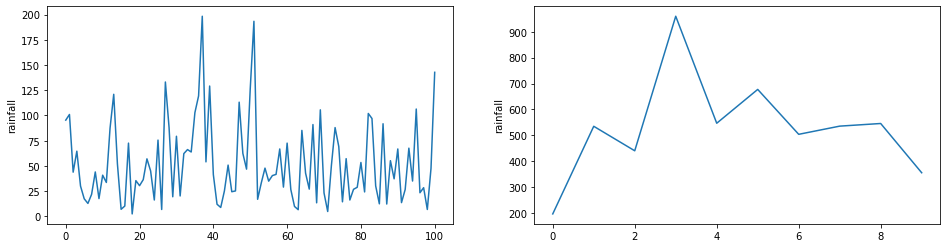

In [176]:
c = cities['Canberra']

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

c2 = c.groupby(by=['year','month']).sum().drop(columns='quinzena').reset_index()
c3 = c.groupby(by=['year']).sum().drop(columns=['quinzena','month']).reset_index()
sns.lineplot(x=c2.index, y='rainfall',data=c2,ax=ax[0])
sns.lineplot(x=c3.index, y='rainfall',data=c3,ax=ax[1])

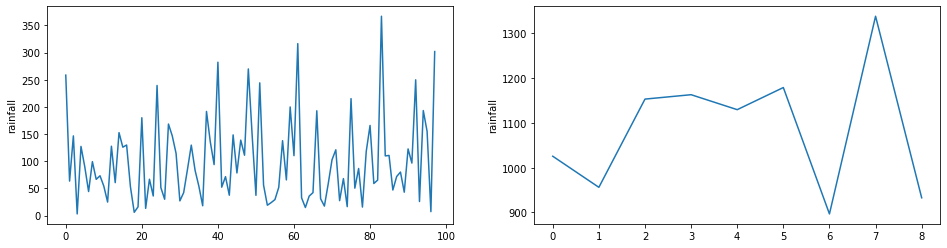

In [177]:
c = cities['Sydney']

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

c2 = c.groupby(by=['year','month']).sum().drop(columns='quinzena').reset_index()
c3 = c.groupby(by=['year']).sum().drop(columns=['quinzena','month']).reset_index()
sns.lineplot(x=c2.index, y='rainfall',data=c2,ax=ax[0])
sns.lineplot(x=c3.index, y='rainfall',data=c3,ax=ax[1])

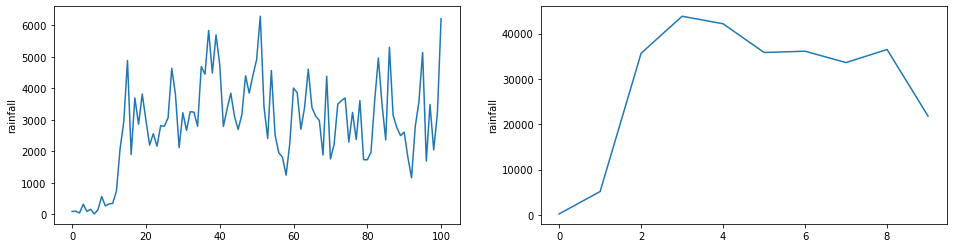

In [178]:
c = bob

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

c2 = c.groupby(by=['year','month']).sum().drop(columns='quinzena').reset_index()
c3 = c.groupby(by=['year']).sum().drop(columns=['quinzena','month']).reset_index()
sns.lineplot(x=c2.index, y='rainfall',data=c2,ax=ax[0])
sns.lineplot(x=c3.index, y='rainfall',data=c3,ax=ax[1])

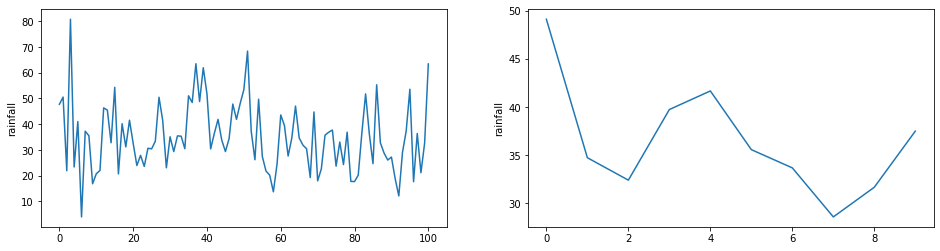

In [179]:
c = bob

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))

c2 = c.groupby(by=['year','month']).mean().drop(columns='quinzena').reset_index()
c3 = c.groupby(by=['year']).mean().drop(columns=['quinzena','month']).reset_index()
sns.lineplot(x=c2.index, y='rainfall',data=c2,ax=ax[0])
sns.lineplot(x=c3.index, y='rainfall',data=c3,ax=ax[1])

Talvez implementar médias móveis

# Taking a second baseline

Since we already figured out some columns that will leak "answers" or confusing informations for or model, we can drop them and create a new baseline

In [282]:
#reload data:
data = pd.read_csv('raw_data_backup.csv')

**Discarding Data:**

At a first try, we will desconsider columns with > ~40% of missing, since is close to half of the dataset!

Columns with more than 10% NaN are:

- evaporation         42.789026
- sunshine            47.692924
- cloud9am            37.735332
- cloud3pm            40.152469

We will consider to use them later, maybe the missing is only a zero value!

In [283]:
data = data.drop(['evaporation', 'sunshine', 'cloud9am', 'cloud3pm'],axis=1)

**Dropping some other columns**

- ***modelo_vigente***: this column is the results of a prediction model, we won't need it for fitting the model, only for further comparations
- sometimes, its common to use other models at the feed of a new model. One risk of this, however, is that in case the auxiliary model is discontinued (in our case, the "modelo_vigente"), the main model reamins outdated.

In [284]:
data = data.drop('modelo_vigente',axis=1)

**Dropping *temp***

*temp* is clearly dependend of the max temperature, and also has some missing values

In [285]:
data = data.drop('temp', axis=1)

**Dropping *rainfall* and *amountOfRain***

Those variables are already represented by raintoday and raintomorrow, but we can come back later

In [286]:
data = data.drop(['rainfall','amountOfRain',],axis=1)

Future ideas:
    - verify relationship between precipitation and raintomorrow/raintoday

**NEW BASELINE**

In [287]:
# teste dataframe, no cities and no season!
before = data.loc[data.loc[:,'date'] <= '2016-06-24'].dropna()
after = data.loc[data.loc[:,'date'] > '2016-06-24'].dropna()

In [288]:
# Train and test
X_train = pd.get_dummies(before.drop(['date','raintomorrow'],axis=1))
y_train = before.loc[:,'raintomorrow']

X_test = pd.get_dummies(after.drop(['date','raintomorrow'],axis=1))
y_test = after.loc[:,'raintomorrow']

for col in X_train.columns:
    if col not in X_test.columns:
        X_test[col] = 0

In [289]:
# Standardize data:
scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)

X_test_std = scaler.transform(X_test)

**Logistic regression**

In [290]:
#instantiate the model and fit
logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train_std, y_train)

# let's evaluate - new data comes in:
predictions = logreg.predict(X_test_std)
pred_proba = logreg.predict_proba(X_test_std)[:,1]
accuracy_score(y_test, predictions)

0.8332970935710662

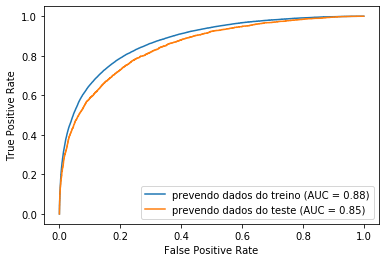

In [262]:
# results
fig, ax = plt.subplots()

plot_roc_curve(logreg, X_train_std, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(logreg, X_test_std, y_test, ax=ax, name = 'prevendo dados do teste')
plt.show();

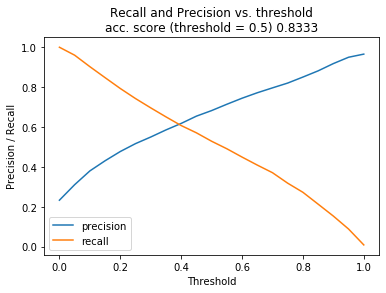

In [309]:
plot_prec_and_rec(pred_proba, y_test)

# Feature Engineering: Creating Data

As next steps, it was brainstormed how it was possible to better up our current variables. One main worry was how "locations" could be translated into more concrete values for the model. This happens because locations represent places in the world, with true distances and local geo conditions, and not only "ones and zeros" as seen by functions like pd.get_dummies()

It was idealized that locations would give means to:
- latitude
- longitude

And dates woudl give space for:
- months
- seasons

**Create a columns for month and create a column for season**

In [22]:
data['month'] = data.loc[:,'date'].apply(lambda x: x.month)

seasons = {12:'Summer', 1:'Summer', 2:'Summer', 
             3:'Autumn', 4:'Autumn', 5:'Autumn',
             6:'Winter', 7:'Winter', 8:'Winter',
             9:'Spring', 10:'Spring', 11:'Spring'}

data['season'] = data.loc[:,'month'].apply(lambda x: seasons[x])

**Formating location**

- some locations need to be formated and words separated (i.e. BadgerysCreek to Badgerys Creek)

In [23]:
data['location'] = data['location'].str.replace(r"([A-Z]+)", r" \1").str.strip()

**Adding a mean value for the proportion of raining the next day for each city**

- *raintomo_mean*: will be the respective prob of rain the next day for the current city. Its the sum of 'raintomorro' by the total of rows of the city.

In [24]:
# get a df of mean prob of raining the next day for each city
rainto_mean = data[['location', 'raintomorrow']].groupby(by='location').mean().reset_index()

my_dict = {}

for loc in rainto_mean.location.unique():
    my_dict[loc] = round(rainto_mean.query(f'location == "{loc}"').raintomorrow.values[0],4)
    
data['loc_rainto_mean'] = data.location.apply(lambda x: my_dict[x])

**Adding a mean value for the proportion of raining the next day for each *wind_direction***

- *raintomo_mean*: will be the respective prob of rain the next day for the current city. Its the sum of 'raintomorro' by the total of rows of the city.

In [25]:
# get a df of mean prob of raining the next day for each wind_direction
wind_rainto_mean = data[['wind_gustdir', 'raintomorrow']].groupby(by='wind_gustdir').mean().reset_index()

for loc in wind_rainto_mean.wind_gustdir.unique():
    my_dict[loc] = round(wind_rainto_mean.query(f'wind_gustdir == "{loc}"').raintomorrow.values[0],4)
    
data['wind_rainto_mean'] = data.wind_gustdir.apply(lambda x: my_dict[x] if type(x) == str else x)

**Adding coorinates (*lat*, *lon*) columns and dropping *location***

- We will add latitude and longitude as a mean for transforming the location in numeric values, instead of using them with get_dummies.
- We won't need location anymore so we will drop them

In [26]:
geolocator = Nominatim(user_agent="my-application")

unique_loc = data['location'].unique()

for city in tqdm(unique_loc):
    geoloc = geolocator.geocode(city,'Australia')
    my_dict[city + '_lat'] = geoloc.latitude
    my_dict[city + '_lon'] = geoloc.longitude

data['location_lat'] = data.location.apply(lambda x: my_dict[x + '_lat'] if type(x) == str else x)
data['location_lon'] = data.location.apply(lambda x: my_dict[x + '_lon'] if type(x) == str else x)

100%|██████████| 49/49 [00:37<00:00,  1.32it/s]


**Saving a backup csv**

In [29]:
data.to_csv('data_backup.csv',index=False)

**Loading backup when needed**

In [5]:
data = pd.read_csv('data_backup.csv')
data.loc[:,'date'] = pd.to_datetime(data.loc[:,'date'])

# Tobogã: testing models

## Preparing Data: X and y (train and test) and comparison with *modelo_vigente*

At first, it was studied to fill the missing values (for float columns at least). At first, it was decided that it would be fair to fill the values using the mean, applying by each month and each city.

What was found is that some cities for some months had columns filled only with missing values (NaNs)

The results proved to be fruitless. Any other attempt to fill the values with zeros or even the median didn't improve any model.

For this reason, the variable fill_nas will be False. The code for filling the missing values will be kept below as record.

It is worth mentioning that when filling missing values with the mean, one must be cautious for not using test data on the train data.

In [51]:
fill_nas = False

#teste dataframe, no cities and no season!
teste = data.drop(['rainfall','amountOfRain',],axis=1)

before = teste.loc[teste.date <= '2016-06-24']
after = teste.loc[teste.date > '2016-06-24']

In [ ]:
def fill_nas_with_mean(before):
    
    """
     Usar funções para deixar codigos visualmente mais autoexplicativos é uma boa solução, fica mais objetivo.
     o truque é usar a docstring da função para explicar.
    """
    
    #fill cloufs with zero   
#     teste['cloud9am'].fillna(0, inplace=True)
#     teste['cloud3pm'].fillna(0, inplace=True)
    
    #select float columns with NaN
    cols = list(before.loc[:,before.isna().any()].select_dtypes('float').columns)
    locs = before.location.unique()

    #filling NaN with mean values of the month
    deef = pd.DataFrame()

    for month in tqdm(np.arange(1,13)):
        for loc in locs:
            #query the df with location and month and store in a temporary df: lo_cdf
            lo_cdf = before.loc[:,['location'] + cols].loc[before.month == month].query(f'location == "{loc}"')

            #applying the modifications to lo_cdf
            lo_cdf.loc[:,cols] = lo_cdf.loc[:,cols].apply(lambda x: x.fillna(np.mean(x)), axis=1)

            #store in a dataframe
            deef = pd.concat([deef,lo_cdf])

    before.loc[:,['location'] + cols] = deef.sort_index()
    
    return before

In [53]:
# generate NaNs as mean, when needed: 
if fill_nas:
    
    before =  fill_nas_with_mean(before)
    
    before = before.drop(columns='location').dropna()
    after = after.drop(columns='location').dropna()
        
else:
    #now dropping
    before = before.drop(columns='location').dropna()
    after = after.drop(columns='location').dropna()


100%|██████████| 12/12 [03:16<00:00, 16.41s/it]


In [24]:
#saving a backup
teste = pd.concat([before,after])
teste.to_csv('teste_backup_0504.csv',index=False)

In [60]:
#loading backup when needed
teste = pd.read_csv('teste_backup_0504.csv')
before = teste.loc[teste.date <= '2016-06-24']
after = teste.loc[teste.date > '2016-06-24']

*REMINDER*: WE CAN KEEP 'raintoday' COLUMN SINCE WE WILL USE THE LAST YEAR FOR TESTING

In [61]:
#determine X and y
X_train = pd.get_dummies(before.drop(['raintomorrow','date'],axis=1))
y_train = before.loc[:,'raintomorrow']
    
X_test = pd.get_dummies(after.drop(['raintomorrow','date'],axis=1))
y_test = after.loc[:,'raintomorrow']

X_train.shape[1] == X_test.shape[1]

True

In [62]:
# Standardize data:
scaler = StandardScaler().fit(X_train)

X_train_std = scaler.transform(X_train)

X_test_std = scaler.transform(X_test)

In [63]:
path = 'processo_cientista-master/data/'

#import modelo_vigente
modelo_vigente = pd.read_csv(path+'rain_data_aus.csv').dropna().modelo_vigente

## MODELO_VIGENTE ROC CURVE
dframe = pd.read_csv(path+'rain_data_aus.csv')
mv_y_pred_prob = dframe.modelo_vigente
mv_y_test = dframe.raintomorrow.apply(lambda x: 1 if x == 'Yes' else 0)

## PCA

PCA was used in order to give us possible hints on which the parameters influence the results.

An interesting observation is that when PCA reduces the data to two parameters, only 13% of the information is maintained. However, even with 13% it is possible, on the PCA figure below, to check that we have an interesting mix and visual separation between the observations of the dataset, when they are colored by the possible values of raintomorrow (= 1 and = 0).

each pca explains: [0.07877261 0.05191084]
Both components explain together 13.07% of the data

original shape:    (112925, 72)

transformed shape: (99128, 2)


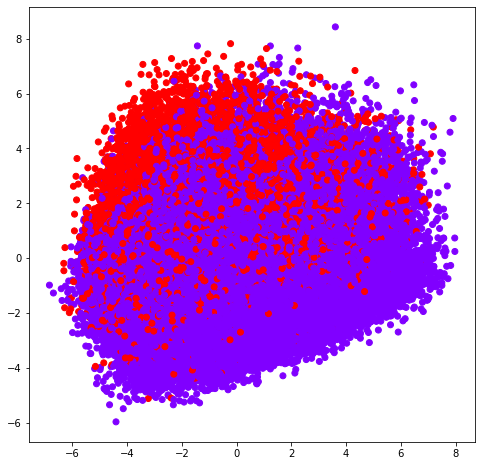

In [124]:
# instantiate and fit the pca object
X_std = StandardScaler().fit_transform(X_train)

pca = PCA(n_components=2)
pca.fit(X_std)

print(f'each pca explains: {pca.explained_variance_ratio_}')
explains = pca.explained_variance_ratio_.sum()
print(f'Both components explain together {round(explains*100,2)}% of the data')

#now transform!
X_pca = pca.transform(X_std)

#check results
print("\noriginal shape:   ", X.shape)
print("\ntransformed shape:", X_pca.shape)
pc1 = X_pca[:,0]
pc2 = X_pca[:,1]

fig, axe = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
axe.scatter(x=pc1, y=pc2, c=y_train, cmap='rainbow',)

## Taking the mean

In [23]:
the_mean = y_train.mean()
y_pred = y_train.apply(lambda x: the_mean).iloc[0:y_test.shape[0]]
y_pred = y_pred.apply(lambda x: 1 if x>0.5 else 0)

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test,y_pred).ravel()
confusion_matrix(y_true= y_test, y_pred= y_pred)

array([[10583,     0],
       [ 3214,     0]], dtype=int64)

In [24]:
#(max_iter=100)
print('recall_score: ', recall_score(y_true= y_test, y_pred= y_pred))
print('precision_score: ', precision_score(y_true= y_test, y_pred= y_pred))
print('accuracy_score: ', accuracy_score(y_true= y_test, y_pred= y_pred))

recall_score:  0.0
precision_score:  0.0
accuracy_score:  0.7670508081466986


c:\users\vfarn\appdata\local\programs\python\python38-32\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Logistic regression

In [64]:
#instantiate the model and fit
logreg = LogisticRegression(max_iter=1000)

logreg.fit(X_train_std, y_train)

# let's evaluate - new data comes in:
predictions = logreg.predict(X_test_std)
pred_proba = logreg.predict_proba(X_test_std)

results = pd.DataFrame({'prob_not_rain': pred_proba[:,0], 
                          'prob_rain': pred_proba[:,1], 
                          'predictions':predictions,
                          'y_test':y_test})

accuracy_score(y_test, predictions)

0.8440965427266797

In [65]:
tn, fp, fn, tp = confusion_matrix(y_test,predictions).ravel()
confusion_matrix(y_true= y_test, y_pred= predictions)

array([[9983,  600],
       [1551, 1663]], dtype=int64)

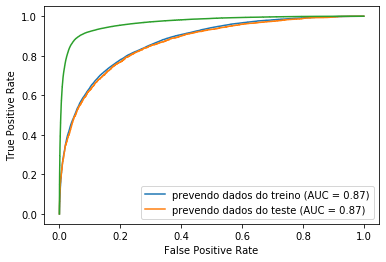

In [66]:
# results
fig, ax = plt.subplots()

plot_roc_curve(logreg, X_train_std, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(logreg, X_test_std, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Logistic Regression')
plt.show();

start: 23:49:27
end: 23:51:22


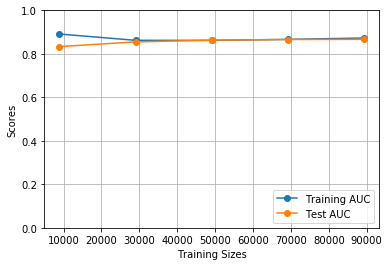

In [150]:
make_my_learn_curve(model=logreg, X_train=X_train_std, y_train=y_train)

## Decision Trees

Remember: we don't need to standardize the data here!




  0%|          | 0/9 [00:00<?, ?it/s]


 11%|█         | 1/9 [00:01<00:11,  1.45s/it]


 22%|██▏       | 2/9 [00:03<00:11,  1.63s/it]


 33%|███▎      | 3/9 [00:06<00:11,  1.96s/it]


 44%|████▍     | 4/9 [00:10<00:12,  2.57s/it]


 56%|█████▌    | 5/9 [00:15<00:13,  3.27s/it]


 67%|██████▋   | 6/9 [00:20<00:11,  3.83s/it]


 78%|███████▊  | 7/9 [00:25<00:08,  4.39s/it]


 89%|████████▉ | 8/9 [00:31<00:04,  4.87s/it]


100%|██████████| 9/9 [00:38<00:00,  4.29s/it]


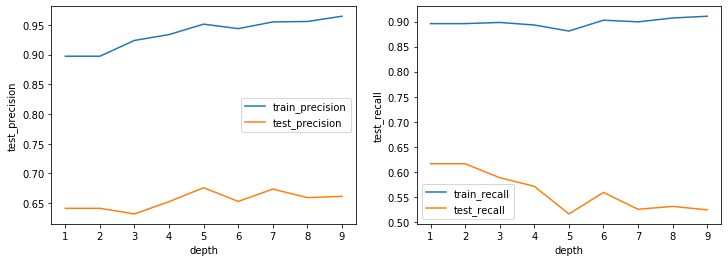

In [74]:
df = pd.DataFrame()

for N in tqdm(np.arange(1,10,1)):

    tree = DecisionTreeClassifier(max_depth=N)
    tree.fit(X_train, y_train)

    # TRAIN SET and get precision and recall
    tn, fp, fn, tp = confusion_matrix(y_train,tree.predict(X_train)).ravel()
    a1, a2 = tp / (fp + tp), tp / (fn + tp)

    # TEST SETand get precision, recall and test_score
    tn, fp, fn, tp = confusion_matrix(y_test,tree.predict(X_test)).ravel()
    a3, a4 = tp / (fp + tp), tp / (fn + tp)
    test_score = (tn + tp)/(tn + fp + fn + tp)


    minidf = pd.DataFrame({'depth':N, 'train_precision':a1, 
                          'train_recall':a2, 'test_precision':a3,
                          'test_recall':a4, 'test_score':test_score}, index=[0])
    df = pd.concat([df,minidf])
    
df = df.reset_index(drop=True)

fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4))

sns.lineplot(x='depth', y='train_precision', data=df, label = 'train_precision',ax=ax[0])
sns.lineplot(x='depth', y='train_recall', data=df, label = 'train_recall',ax=ax[1])
sns.lineplot(x='depth', y='test_precision', data=df, label = 'test_precision',ax=ax[0])
sns.lineplot(x='depth', y='test_recall', data=df, label = 'test_recall',ax=ax[1])

accuracy_score:  0.8332246140465318


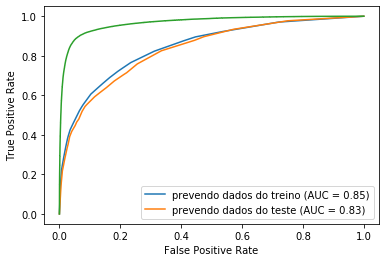

In [130]:
# fit with max_depth=7
tree = DecisionTreeClassifier(max_depth=5)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print('accuracy_score: ', acc_score)

# results
fig, ax = plt.subplots()

plot_roc_curve(tree, X_train, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(tree, X_test, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Decision Tree')
plt.show();

start: 23:52:32
end: 23:53:48


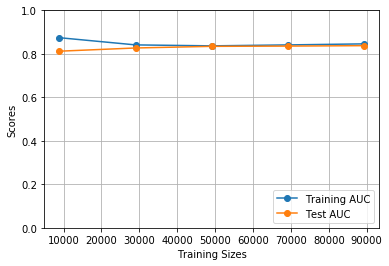

In [152]:
make_my_learn_curve(model=tree, X_train=X_train, y_train=y_train)

## Bagging

In [132]:
bagging = BaggingClassifier(
            base_estimator= None, #DecisionTreeClassifier(max_depth=3), 
            n_estimators=10,
            oob_score=True, n_jobs=-1)

In [133]:
print('start:', datetime.now().strftime('%H:%M:%S'))
results = cross_val_score(bagging, X_train, y_train, 
                          cv= KFold(10, shuffle=True), 
                          scoring='roc_auc')
(np.mean(results), np.std(results))
print('end:', datetime.now().strftime('%H:%M:%S'))

start: 23:28:16
end: 23:30:19


start: 23:30:21
accuracy_score:  0.8382257012393999


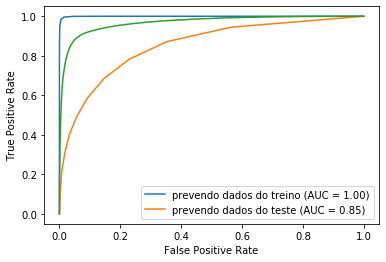

end: 23:30:37


In [134]:
print('start:', datetime.now().strftime('%H:%M:%S'))
bagging.fit(X_train, y_train)

y_pred = bagging.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print('accuracy_score: ', acc_score)

# results
fig, ax = plt.subplots()

plot_roc_curve(bagging, X_train, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(bagging, X_test, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Decision Tree')
plt.show();
print('end:', datetime.now().strftime('%H:%M:%S'))

start: 23:57:08
end: 00:03:47


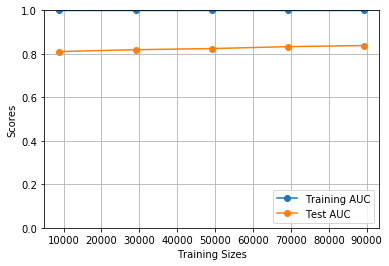

In [153]:
make_my_learn_curve(model=bagging, X_train=X_train, y_train=y_train)

## Random Forests

In [136]:
print('start:', datetime.now().strftime('%H:%M:%S'))

forest = RandomForestClassifier(max_depth=7, n_estimators=100, n_jobs=-1)

results = cross_val_score(forest, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

print('end:', datetime.now().strftime('%H:%M:%S'))

start: 23:34:09
end: 23:35:06


start: 23:35:08
accuracy_score:  0.8358338769297673


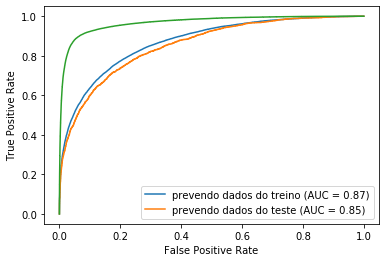

end: 23:35:15


In [137]:
print('start:', datetime.now().strftime('%H:%M:%S'))
forest.fit(X_train, y_train)

y_pred = forest.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print('accuracy_score: ', acc_score)

# results
fig, ax = plt.subplots()

plot_roc_curve(forest, X_train, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(forest, X_test, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Decision Tree')
plt.show();
print('end:', datetime.now().strftime('%H:%M:%S'))

start: 00:31:18
end: 00:33:50


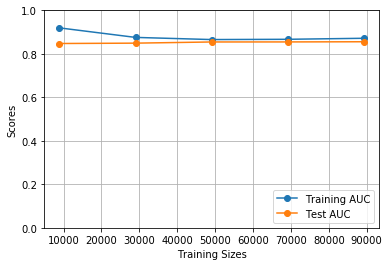

In [154]:
make_my_learn_curve(model=forest, X_train=X_train, y_train=y_train)

## Adaboost

In [139]:
print('start:', datetime.now().strftime('%H:%M:%S'))

adaboost = AdaBoostClassifier(
            base_estimator=DecisionTreeClassifier(max_depth=1),
            n_estimators=50,
            learning_rate=.05)

print('adaboost ready!')

results = cross_val_score(adaboost, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

print('end:', datetime.now().strftime('%H:%M:%S'))

start: 23:37:01
adaboost ready!


KeyboardInterrupt: 

In [ ]:
print('start:', datetime.now().strftime('%H:%M:%S'))
adaboost.fit(X_train, y_train)

y_pred = adaboost.predict(X_test)

acc_score = accuracy_score(y_test, y_pred)
print('accuracy_score: ', acc_score)

# results
fig, ax = plt.subplots()

plot_roc_curve(adaboost, X_train, y_train, ax=ax, name = 'prevendo dados do treino')
plot_roc_curve(adaboost, X_test, y_test, ax=ax, name = 'prevendo dados do teste')

fpr, tpr, thresholds = roc_curve(mv_y_test, mv_y_pred_prob)
plt.plot(fpr, tpr, label='Decision Tree')
plt.show();
print('end:', datetime.now().strftime('%H:%M:%S'))

In [155]:
make_my_learn_curve(model=adaboost, X_train=X_train, y_train=y_train)

start: 00:33:52


KeyboardInterrupt: 

## XGBoost

In [87]:
xgb = XGBClassifier(max_depth=1, 
                    n_estimators=50, 
                    colsample_bytree=0.7, 
                    n_jobs=-1)

NameError: name 'XGBClassifier' is not defined

In [ ]:
results = cross_val_score(xgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

In [ ]:
curves = learning_curve(xgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

## LightGBM

In [ ]:
lgb = LGBMClassifier(max_depth=1, n_estimators=100, colsample_bytree=.7, n_jobs=-1)

In [ ]:
results = cross_val_score(lgb, X_train, y_train, cv=KFold(10, shuffle=True), scoring='roc_auc')
(np.mean(results), np.std(results))

In [ ]:
curves = learning_curve(lgb, X_train, y_train, scoring='roc_auc')
train_sizes = curves[0]
train_scores = curves[1]
test_scores = curves[2]

plt.plot(train_sizes, train_scores.mean(axis=1),'-o')
plt.plot(train_sizes, test_scores.mean(axis=1),'-o');
plt.ylim([0.5, 1])
plt.grid()

In [ ]:
plot_importance(lgb, importance_type='gain')

## Manual log:
- mean() acc_score: 0.767051
- logreg acc_score: 0.844313
- logreg auc_test: 0.87
- tree acc_score: 0.83793578
- tree auc_test: 0.85

# Things to consider

Who is your client?

 > If the client is a simple person, how would you answer?

 > If the client is a farmer, wanting to collect his crops, how would you answer?

 > You should base this answers in propabilistc answers, by varying the % and precision and recall. % is the treshold.

What are you trying to answer?